In [328]:
import numpy as np
import matplotlib.pyplot as plt
from Helper import *

In [187]:
#GRAPHS#
SMALL_SIZE = 22
MEDIUM_SIZE = 22
BIGGER_SIZE = 26

plt.rcParams['figure.figsize'] = [24, 8]

blue = 'royalblue'
red = 'crimson'
col1 = 'darkmagenta'
col2 = 'goldenrod'
col3 = 'mediumturquoise'
col4 ='forestgreen'

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [163]:
# constants

# 0 - male, 1 - female 
gender = [1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, # player 0 - 16
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, # 17 - 32
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, # 33 - 48
         0, 0, 0, 0, 1, 1, 1, 1, 0, 0 ,0 ,0, 0, 0, 0, 0 ] # 49 - 64 

# body, leftUpperArm, RightUpperArm, RightFoot, LeftFoot, LeftHand, RightHand
bodyPartsGroups= [0,1,1,2,2,3,3]
# 0 = right, 1 = hand
hand = [0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1]
gen = [0,1,1,1,0,0,0,0,1,1,1,1,0,1,0,0]
height = [1.7, 1.73, 1.65, 1.72, 1.77, 1.82, 1.81, 1.79, 1.6, 1.7, 1.7, 1.65, 1.8, 1.78, 1.84, 1.85 ]
colours = ["royalblue",col1, col3, col3, col1, col1, col3,
           "royalblue",col2, col4, col4, col2, col2, col4,"crimson","royalblue","royalblue"]
armLength = [28,23.5,27,27, 28, 27, 28, 26, 23, 26, 24, 26, 27, 24, 29, 29]
vrLength = [4.94, 3.90, 2.49, 3.39, 5.27, 5.09, 7.19, 4.14, 6.20, 3.00, 4.21, 4.90, 5.45, 2.87, 6.95, 2.70]
realLength = [ a * b / 100 for (a,b) in zip(armLength,vrLength) ]

weightPercentageMale = [0.551, 0.0325, 0.0325, 0.1668, 0.1668, 0.0252, 0.0252]
weightPercentageFemale = [0.532, 0.029, 0.029, 0.1843, 0.1843, 0.0207, 0.0207]

playersTraining = [2, 7, 11, 14, 18, 22, 26, 30, 34, 38, 42, 46, 50, 54, 58, 62]
playersBaseline = [4, 9, 13, 16, 19, 24, 28, 31, 36, 39, 43, 48, 51, 56, 60, 63]
playersOptimal  = [3, 8, 12, 15, 20, 23, 27, 32, 35, 40, 44, 47, 52, 55, 59, 64]

path = "E:\\Andreea\\Master\\Thesis\\Git\\TheOne\\SmartuistWrapper\\tapResultParticipants.csv"
pathH = "C:\\Users\\huber\\OneDrive\\Dokumenty\\thesis-hubert\\unity\\SmartuistWrapper\\tapResultParticipants.csv"

In [135]:
def getStatisticsPhase3(results, players, limitLessons = 2):
    mvmTime = [] 
    gain = []
    efforBodyParts = []
    distBodyParts = []
    throughput = []
    for p in players:
        tmp = results[p]
        time = 0
        count = 0
        th = 0
        gain.append(getGainPerPlayer(p, results))
        effort, dist = EffortPerBodyPartPerPlayerSummed(p, results,10, limitLessons)
        efforBodyParts.append(effort)
        distBodyParts.append(dist)
        for words in tmp:
            if int(words[1]) < 2:
                time += float(words[10])
                th += float(words[11]) / (float(words[10]) / 1000) # recompute as id/time (not normalized id)
                count += 1
        throughput.append(th/count)        
        mvmTime.append(time/1000) # time in seconds
    return (mvmTime, gain, efforBodyParts, distBodyParts, throughput)

# computes the gain for the player (from effort per body part and throughput)
def getGainPerPlayer(p, results):
    gain = [] 
    batchSize = 10
    nrLessons = 2
    playerResults = results[p]
    for l in range(nrLessons):
        stupidTh = 0 
        sumTh = 0
        bodyParts =[ 0 for i in range(7)]
        for res in playerResults: #results for a repetition  
            if(l == int(res[1])):
                for i in range (7):
                    bodyParts[i] += 1 / float(res[21+i])
                sumTh += float(res[13])
                stupidTh += sumTh
        
        bodyParts = [ x / batchSize for x in bodyParts]
        gainEffort = sum(bodyParts) / len(bodyParts)
        gainTh = stupidTh / batchSize
        gain.append((gainEffort + gainTh) / 2)
    
    return np.average(gain)

# get effort and distance per body parts
def EffortPerBodyPartPerPlayerSummed(p, results, batchSize, limitLessons):
    effortBodyParts = [ 0 for i in range(7)]
    distBodyParts = [ 0 for i in range(7)]
    tmp = results[p]
    counter = 0
    for words in tmp:
        if int(words[1]) < limitLessons:
            for i in range (7):
                effortBodyParts[i] += float(words[21+i])
                distBodyParts[i] += float(words[14+i])

            counter = counter + 1
            if counter == batchSize:
                counter = 0
            if counter == 0:
                for i in range(7):
                    effortBodyParts[i] /= batchSize
                    distBodyParts[i] /= batchSize
    return (effortBodyParts, distBodyParts)

# get effort and distance per body parts
def EffortPerBodyPartPerPlayerAll(p, results, batchSize, limitLessons):
    effortBodyParts = [ [] for i in range(7)]
    distBodyParts = [ [] for i in range(7)]
    tmp = results[p]
    counter = 0
    for words in tmp:
        if int(words[1]) < limitLessons:
            for i in range (7):
                effortBodyParts[i].append(float(words[21+i]))
                distBodyParts[i].append(float(words[14+i])) 
    return (effortBodyParts, distBodyParts)

# a list with the results at idx for the given player    
def getResultPerPlayer(p, results, idx, unique ):
    tmp = results[p]
    values = []
    for words in tmp:
        values.append(float(words[idx]))
    if (unique == True):
        values =  [x for i, x in enumerate(values) if i == values.index(x)]
    return values

# sort list1 - use the indexes of the sorted list1 to rearrage list2    
def getCombinedPlot(list1, list2):
    idx   = np.argsort(list1)
    list1 = np.array(list1)[idx]
    list2 = np.array(list2)[idx]  
    return (list1, list2)

def EffortPerBodyPartPerPlayer(p, results):
    bodyParts =[ [0]*1 for i in range(7)]
    distBodyParts = [[0] * 1 for i in range (7)]
    tmp = results[p]
    counter = 0
    for words in tmp:            
        for i in range (7):
            bodyParts[i][bodyParts[i].index(bodyParts[i][-1])] += float(words[21+i])
            distBodyParts[i][distBodyParts[i].index(distBodyParts[i][-1])] += float(words[14+i])
        counter = counter + 1
        if counter == 10:
            counter = 0
        if counter == 0:
            for i in range(7):
                bodyParts[i][bodyParts[i].index(bodyParts[i][-1])] /= 10
                bodyParts[i].append(0)
                distBodyParts[i][distBodyParts[i].index(distBodyParts[i][-1])] /= 10
                distBodyParts[i].append(0)
    return (bodyParts, distBodyParts)

In [327]:
# statistics for phase 2
from scipy.stats import pearsonr, spearmanr, kendalltau, ttest_rel, wilcoxon, normaltest, mannwhitneyu

def stats(data, lable):
    median = np.median(data)
    upper_quartile = np.percentile(data, 75)
    lower_quartile = np.percentile(data, 25)
    iqr = upper_quartile - lower_quartile
    print(lable, "{:.2f} & {:.2f}".format(median, iqr))
    print(" ")

def isNormal(x):
    k2, p = normaltest(x)
    alpha = 1e-3
    #print("p = {:g}".format(p))
    p = 3.27207e-11
    if p < alpha:  # null hypothesis: x comes from a normal distribution
        #rint("The null hypothesis can be rejected")
        return False
    else:
       #print("The null hypothesis cannot be rejected")
        return True

# wicloxen is not-parametric (can be used when the data is not uniformly distributed and there are outliners)
def findCorelationPairs(data1, data2, label=""):
    print(label) 
    
    isNormal(data1)
    isNormal(data2)
    
    if(isNormal(data1) and isNormal(data2)):
        print("Data normaly distributed")
        stats, p = ttest_rel(data1, data2)    
        print('Paired t test  p-value / coef: %.2f &' % stats, p) # for continuos independent var  
    else:    
        print("Data not normaly distributed")
        stats, p = wilcoxon(data1, data2)    
        print('Paired wilcoxon  p-value .coef :  %.2f &' % stats, p) # for continuos independent var  

    stats, p = mannwhitneyu(data1, data2)    
   # print('mann-whitney u test: p-value .coef : %.7f' % p, stats) # for continuos independent var  
             
    

In [302]:
results = readFromFile(path, 0)
mvmTimeBaseline, gainBaseline, effortBaseline, distBaseline, thBaseline = getStatisticsPhase3(results, playersBaseline)
mvmTimeOptimal, gainOptimal, effortOptimal, distOptimal, thOptimal  = getStatisticsPhase3(results, playersOptimal)
mvmTimeFirst2, gainFirst2, effortFirst2, distFirst2, thFirst2  = getStatisticsPhase3(results, playersTraining)


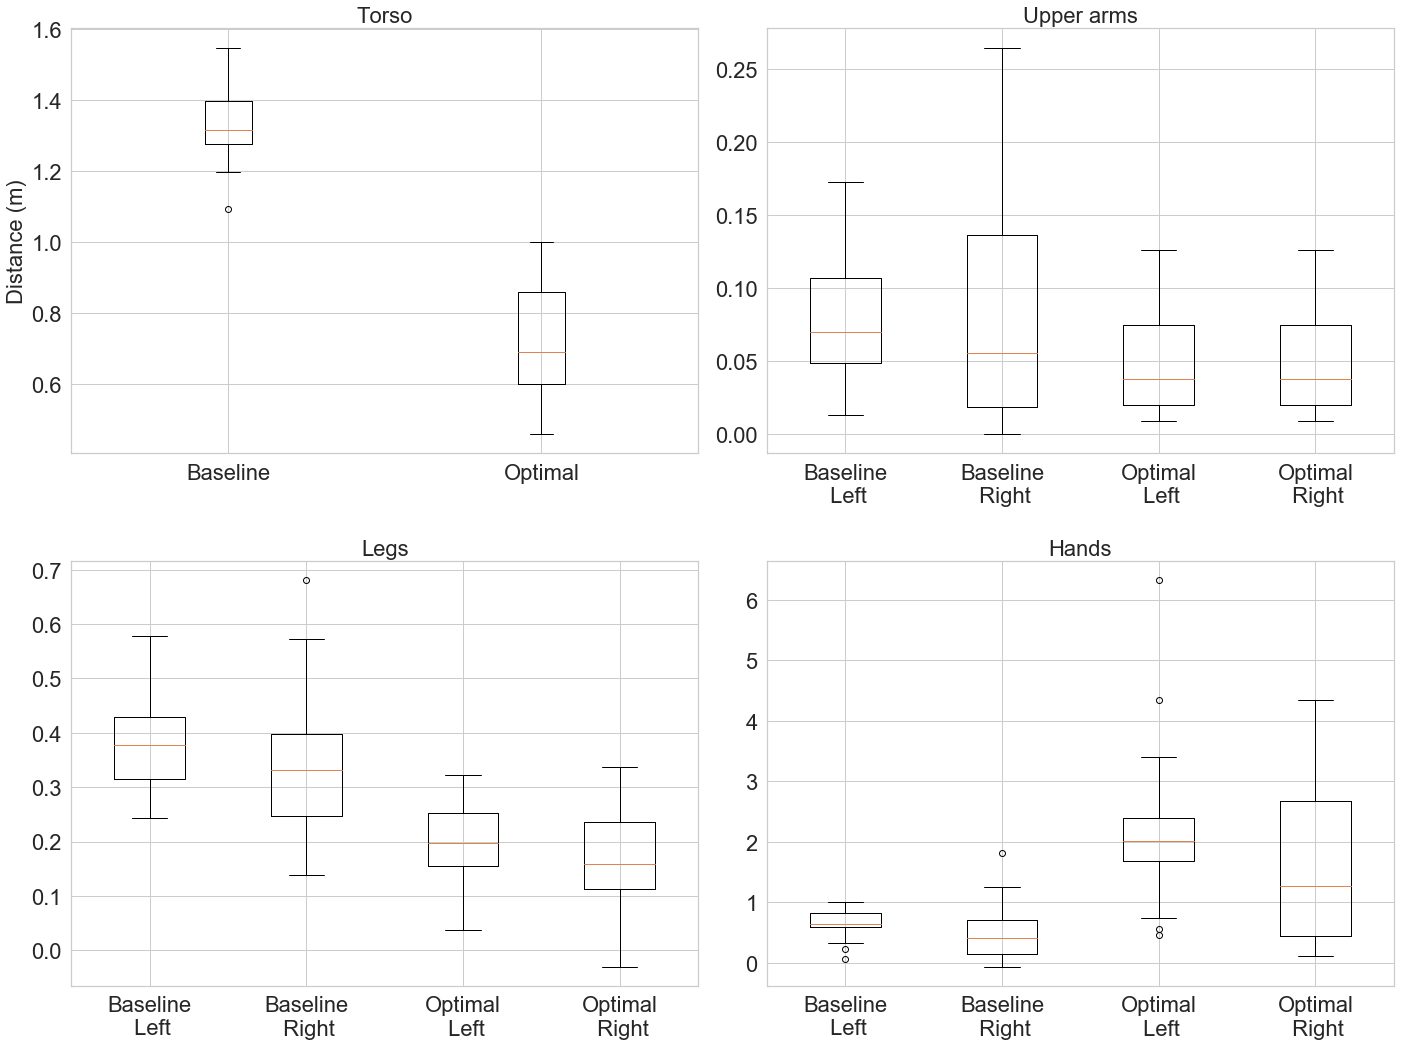

In [324]:
def plotResultsPerBodyPart(baseline, optimal, title, yLabel, filename, legends):
    (l_legend, r_legend) = legends
    bodyParts = ["Body", "Left Upper Arm", "Right Upper Arm" , "Right Foot" , "Left Foot", "Left Hand" , "Right Hand", ]
    baseline = np.array(baseline)
    optimal = np.array(optimal)

    fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize=(20,15))
#     fig.suptitle(title, y = 0.95)
    

    axs[0][0].boxplot([ baseline[:, 0], optimal[:, 0]], labels= [l_legend, r_legend])
    
    base1 = [np.abs(baseline[k][1] - baseline[k][0]) for k in range(len(baseline))]
    base2 = [np.abs(baseline[k][2] - baseline[k][0]) for k in range(len(baseline))]
    optimal1 = [np.abs(optimal[k][1] - optimal[k][0]) for k in range(len(optimal))]
    optimal2 = [np.abs(optimal[k][1] - optimal[k][0]) for k in range(len(optimal))]
    
    axs[0][1].boxplot([ base1, base2, optimal1, optimal2], 
                   labels= [l_legend + "\n Left", l_legend + "\n Right", r_legend +  "\n Left", r_legend + "\n Right"])
    
    base1 = [baseline[k][4] - baseline[k][0] for k in range(len(baseline))]
    base2 = [baseline[k][3] - baseline[k][0] for k in range(len(baseline))]
    optimal1 = [optimal[k][4] - optimal[k][0] for k in range(len(optimal))]
    optimal2 = [optimal[k][3] - optimal[k][0] for k in range(len(optimal))]
    
    axs[1][0].boxplot([ base1, base2, optimal1, optimal2],
                   labels= [l_legend +  "\n Left", l_legend + "\n Right",  r_legend + "\n Left", r_legend + "\n Right"])
    
    base1 = [baseline[k][5] - baseline[k][0] for k in range(len(baseline))]
    base2 = [baseline[k][6] - baseline[k][0] for k in range(len(baseline))]
    optimal1 = [optimal[k][5] - optimal[k][0] for k in range(len(optimal))]
    optimal2 = [optimal[k][6] - optimal[k][0] for k in range(len(optimal))]

    axs[1][1].boxplot([ base1, base2, optimal1, optimal2], 
                   labels= [l_legend +  "\n Left", l_legend + "\n Right", r_legend +  "\n Left", r_legend + "\n Right" ])


    axs[0][0].grid(True)
    axs[0][1].grid(True)
    axs[1][0].grid(True)
    axs[1][1].grid(True)
    axs[0][0].set_ylabel(yLabel)
    axs[0][0].set_title('Torso')
    axs[0][1].set_title('Upper arms')
    axs[1][0].set_title('Legs')
    axs[1][1].set_title('Hands')
    plt.tight_layout(w_pad=0.5, h_pad=1.5)
    plt.savefig(filename,bbox_inches='tight', dpi=150)
    plt.show()


    
    
    
#plotResultsPerBodyPart(effortBaseline, effortOptimal, "Effort per body part", "Effort", "EffortPerBodyPart", ("Baseline", "Optimal"))   
plotResultsPerBodyPart(distBaseline, distOptimal, "Distance per body part", "Distance (m)", "DistancePerBodyPartNew", ("Baseline", "Optimal"))    
#plotResultsPerBodyPart(distBaseline, distFirst2, "Distance per body part", "Distance (m)", "DistancePerBodyPart", ("Phase2", "Phase1"))    


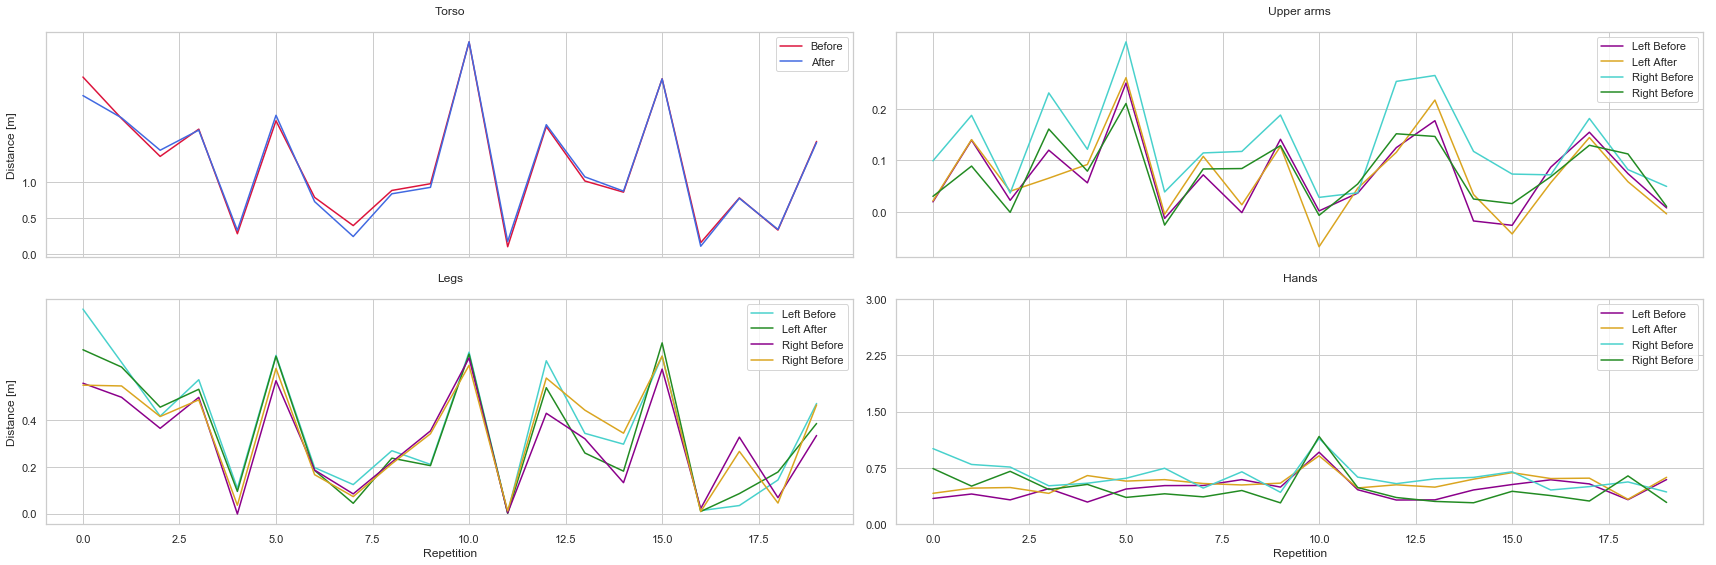

In [166]:

def getAvgPerRepetitionPerBodyPart(players, results):
    distBodyParts1 = []
    for p in players:       
        effort, dist = EffortPerBodyPartPerPlayerAll(p, results,10, 2)
        distBodyParts1.append(dist)

    distBodyParts1 = np.array( distBodyParts1)
    

    dist1 = []
    for i in range(20):
        tmp = distBodyParts1[:,:,i]
        bodyParts = []
        for j in range(7):
            tmp2 = tmp[:,j]
            bodyParts.append(sum(tmp2)/len(tmp2))
        dist1.append(bodyParts)  
    return(dist1)

distPhase1 = getAvgPerRepetitionPerBodyPart(playersTraining, results)
distPhase2 = getAvgPerRepetitionPerBodyPart(playersBaseline, results)


fig, ax = plt.subplots( ncols = 2, nrows=2, sharex=True, sharey=False)
for i in range(len(distPhase1[0])):
   
    y1= np.array(distPhase1)[:, i]
    y2= np.array(distPhase2)[:, i]
    x = range(20)
   
    if (i > 0):
        y1 = [distPhase1[k][i] - distPhase1[k][0] for k in range(len(distPhase1))]
        y2 = [distPhase2[k][i] - distPhase2[k][0] for k in range(len(distPhase2))]
    
    if bodyPartsGroups[i] == 0:
        ax[0][0].plot(x,y1, color = red)
        ax[0][0].plot(x,y2, color = blue)
        ax[0][0].set_title("Torso", y = 1.05)
        ax[0][0].set_yticks(np.arange(0,1.5, 0.5))
        ax[0][0].grid(True)
        ax[0][0].legend(("Before", "After"),loc='best')
    elif bodyPartsGroups[i] == 1:
        ax[0][1].plot(x,y1, color = colours[i])
        ax[0][1].plot(x, y2, color = colours[i+7])
        ax[0][1].set_title("Upper arms", y = 1.05)
        ax[0][1].set_yticks(np.arange(0,0.3, 0.1))
        ax[0][1].grid(True)
        ax[0][1].legend(('Left Before', 'Left After','Right Before', 'Right Before'), loc='best')
    elif bodyPartsGroups[i] == 3: 
        ax[1][1].plot(x,y1, color = colours[i])
        ax[1][1].plot(x, y2, color = colours[i+7])
        ax[1][1].set_title("Hands", y = 1.05)
        ax[1][1].set_yticks(np.arange(0,3.25, 0.75))
        ax[1][1].legend(('Left Before', 'Left After','Right Before', 'Right Before'), loc='best')
        ax[1][1].grid(True)
    else:
        ax[1][0].plot(x,y1, color = colours[i])
        ax[1][0].plot(x, y2, color = colours[i+7])
        ax[1][0].set_title("Legs", y = 1.05)
        ax[1][0].legend(('Left Before', 'Left After','Right Before', 'Right Before'), loc='best')
        ax[1][0].set_yticks(np.arange(0,0.6, 0.2))
        ax[1][0].grid(True)
        
ax[0][0].set_ylabel('Distance [m]')
ax[1][0].set_ylabel('Distance [m]')

ax[1][0].set_xlabel('Repetition')
ax[1][1].set_xlabel('Repetition')
  
plt.tight_layout(w_pad=0.5, h_pad=1.0)

# plt.subplots_adjust(top=1.5, bottom = 0.05)
plt.show()

No handles with labels found to put in legend.


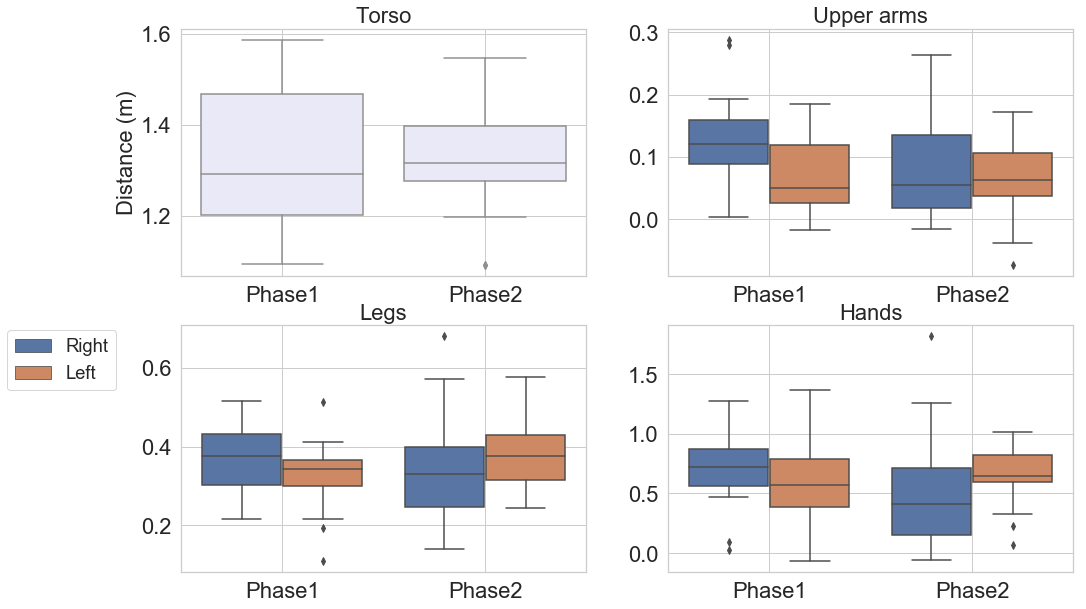

In [319]:
import seaborn as sns
import pandas as pd
bp = ["torso", "Upper arms", "Upper arms", "Legs", "Legs", "Hands",  "Hands"]
distPhase1 = distFirst2 
distPhase2 =  distBaseline
d = []

side = ["All", "Left", "Right", "Right", "Left", "Left", "Right"]
j = 1
#for j in range(7):
d = []
for i in range(len(distPhase1)):
   
    d.append(["Phase1","Right", distPhase1[i][0], 
              distPhase1[i][2] -  distPhase1[i][0],
              distPhase1[i][3] -  distPhase1[i][0],
              distPhase1[i][6] -  distPhase1[i][0],
             ])
    d.append(["Phase2","Right", distPhase2[i][0], 
      distPhase2[i][2] -  distPhase2[i][0],
      distPhase2[i][3] -  distPhase2[i][0],
      distPhase2[i][6] -  distPhase2[i][0],
     ])

    d.append(["Phase1","Left", distPhase1[i][0], 
              distPhase1[i][1] -  distPhase1[i][0],
              distPhase1[i][4] -  distPhase1[i][0],
              distPhase1[i][5] -  distPhase1[i][0],

             ])

    d.append(["Phase2","Left", distPhase2[i][0], 
              distPhase2[i][1] -  distPhase2[i][0],
              distPhase2[i][4] -  distPhase2[i][0],
              distPhase2[i][5] -  distPhase2[i][0]])

data = pd.DataFrame(d)

data.columns= ["Torso", "side", "Torso - Distance (m)",  "Upper arms - Distance (m)",  "Legs - Distance (m)", "Hands - Distance (m)"]
f, axes = plt.subplots(2, 2, figsize=(16,10))
g = sns.boxplot(x="Torso", y="Torso - Distance (m)", data=data, ax=axes[0][0], color='lavender')

axes[0][0].set(title='Torso', ylabel='Distance (m)', xlabel='')
axes[0][0].grid(True)
axes[0][0].legend().remove()
#axes[0].get_legend().remove()

g = sns.boxplot(x="Torso", y="Upper arms - Distance (m)", data=data, ax=axes[0][1], hue="side")
axes[0][1].legend().remove()
axes[0][1].set(title='Upper arms', ylabel='', xlabel='')
axes[0][1].grid(True)
#axes[1].

g = sns.boxplot(x="Torso", y="Legs - Distance (m)", data=data, ax=axes[1][0], hue="side")

axes[1][0].set(title='Legs', ylabel='', xlabel='')
axes[1][0].grid(True)
axes[1][0].legend(bbox_to_anchor=(-0.45,0.7), loc='lower left', fontsize='small')

sns.boxplot(x="Torso", y="Hands - Distance (m)", data=data, ax=axes[1][1], hue="side")
axes[1][1].set(title='Hands', ylabel='', xlabel='')
axes[1][1].grid(True)
axes[1][1].legend().remove()

plt.savefig("BoxPlotPhase1VsPhase2",bbox_inches='tight', dpi=150)

In [292]:
d = []
side = ["All", "Left", "Right", "Right", "Left", "Left", "Right"]
bp = ["Torso", "UpperArms", "UpperArms", "Legs", "Legs", "Hands",  "Hands"]
for j in range(7):
    for i in range(len(distPhase1)):
        if(j == 0):
            d.append(["Phase1", side[j], bp[j], distPhase1[i][0]])
            d.append(["Phase2", side[j], bp[j], distPhase2[i][0]])
        else:
            d.append(["Phase1", side[j], bp[j], distPhase1[i][j] - distPhase1[i][0]])
            d.append(["Phase2", side[j], bp[j], distPhase2[i][j] - distPhase1[i][0]])
            
data = pd.DataFrame(d)

# data.columns= ["Phase", "Side", "Body part",  "Distance (m)"]
# sns.boxplot(data=data, ax=ax, x="Body part", y="Distance (m)", hue="Side")
# f, axes = plt.subplots(1, 4, figsize=(16,6))
# sns.boxplot(x="Phase", y="Distance (m)", data=data, ax=axes[0], hue="Side")
# axes[0].set(title='Torso', ylabel='Distance (m)', xlabel='')
# axes[0].grid(True)

# sns.boxplot(x="Phase", y="Distance (m)", data=data, ax=axes[1], hue="Side")
# axes[1].set(title='Upper arms', ylabel='', xlabel='')
# axes[1].grid(True)

# sns.boxplot(x="Phase", y="Distance (m)", data=data, ax=axes[2], hue="Side")
# axes[2].set(title='Legs', ylabel='', xlabel='')
# axes[2].grid(True)

# sns.boxplot(x="Phase", y="Distance (m)", data=data, ax=axes[3],hue="Side")
# axes[3].set(title='Hands', ylabel='', xlabel='')
# axes[3].grid(True)

In [326]:
bodyParts = ["Body", "Left Upper Arm", "Right Upper Arm" , "Right Foot" , "Left Foot", "Left Hand" , "Right Hand", ]

findCorelationPairs( np.array(distBaseline)[:, 0], np.array(distOptimal)[: ,0], " Dist " + bodyParts[0])
stats(np.array(distBaseline)[:, 0], "distBaseline")
stats(np.array(distOptimal)[: ,0],  "distOptimal")

for i in range(1, 7):   
        y1 = [distBaseline[k][i] - distBaseline[k][0] for k in range(len(distBaseline))]
        y2 = [distOptimal[k][i] - distOptimal[k][0] for k in range(len(distOptimal))]
        findCorelationPairs( np.array(distBaseline)[:, i], np.array(distOptimal)[: ,i], " Dist " + bodyParts[i])
        stats(y1, "distBaseline")
        stats(y2,  "distOptimal")


 Dist Body
Data not normaly distributed
Paired wilcoxon  p-value .coef :  0.00 & 0.00043777719457466354
 
distBaseline 1.32 & 0.12
distOptimal 0.69 & 0.26
 Dist Left Upper Arm
Data not normaly distributed
Paired wilcoxon  p-value .coef :  0.00 & 0.00043777719457466354
 
distBaseline 0.06 & 0.07
distOptimal 0.03 & 0.07
 Dist Right Upper Arm
Data not normaly distributed
Paired wilcoxon  p-value .coef :  0.00 & 0.00043777719457466354
 
distBaseline 0.06 & 0.12
distOptimal 0.03 & 0.05
 Dist Right Foot
Data not normaly distributed
Paired wilcoxon  p-value .coef :  0.00 & 0.00043777719457466354
 
distBaseline 0.33 & 0.15
distOptimal 0.16 & 0.12
 Dist Left Foot
Data not normaly distributed
Paired wilcoxon  p-value .coef :  0.00 & 0.00043777719457466354
 
distBaseline 0.38 & 0.11
distOptimal 0.20 & 0.10
 Dist Left Hand
Data not normaly distributed
Paired wilcoxon  p-value .coef :  11.00 & 0.0032045855456292547
 
distBaseline 0.64 & 0.23
distOptimal 2.01 & 0.71
 Dist Right Hand
Data not normaly

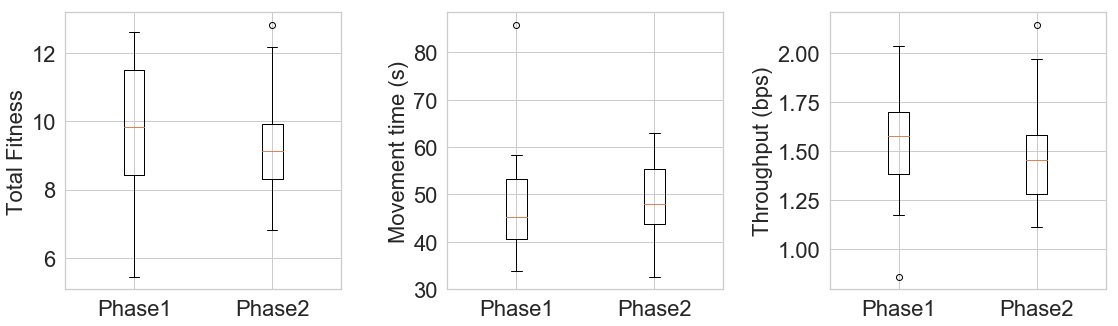

In [218]:
def boxPlotsPerformance(gainBaseline, gainOptimal, mvmTimeBaseline, mvmTimeOptimal, thBaseline, thOptimal, label1, lable2):
    fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize=(16,5))

    axs[0].boxplot([gainBaseline, gainOptimal], labels= [label1, lable2])
    #axs[0].set_title("Total Fitness")
    axs[0].set_ylabel("Total Fitness")
    axs[0].grid(True)

    axs[1].boxplot([ mvmTimeBaseline, mvmTimeOptimal ], labels= [label1, lable2])
    #axs[1].set_title("Movement time")
    axs[1].set_ylabel("Movement time (s)")
    axs[1].grid(True)

    axs[2].boxplot([thBaseline, thOptimal], labels= [label1, lable2])
    #axs[2].set_title("Throughput")
    axs[2].set_ylabel("Throughput (bps)")
    axs[2].grid(True)

    plt.tight_layout()
    plt.savefig("TotalGainMvmTime"+lable2,bbox_inches='tight', dpi=150)

#boxPlotsPerformance(gainBaseline, gainOptimal, mvmTimeBaseline,
#mvmTimeOptimal, thBaseline, thOptimal,"Baseline", "Optimal")
boxPlotsPerformance(gainFirst2, gainBaseline, mvmTimeFirst2, mvmTimeBaseline, 
                    thFirst2, thBaseline, "Phase1", "Phase2")

In [100]:

    
#mvmTimeFirst2, gainFirst2, effortFirst2, distFirst2, thFirst2    
findCorelationPairs(mvmTimeBaseline, mvmTimeFirst2, " Movement ")
findCorelationPairs(gainBaseline, gainFirst2, " Fitness ")
findCorelationPairs(thBaseline, thFirst2, " Throughput ")
   
stats(mvmTimeBaseline, "mvmtimebaseline")
stats(mvmTimeFirst2,  "mvmTimeOptimal")
stats(gainBaseline, "gainBaseline")
stats(gainFirst2, "gainOptimal")
stats(thBaseline, "thBaseline")
stats(thFirst2, "thOptimal")



 Movement 
Data not normaly distributed
Paired wilcoxon  p-value .coef : 0.7959872 63.0
 
 Fitness 
Data not normaly distributed
Paired wilcoxon  p-value .coef : 0.4080442 52.0
 
 Throughput 
Data not normaly distributed
Paired wilcoxon  p-value .coef : 0.4080442 52.0
 
mvmtimebaseline 47.91 & 11.56
mvmTimeOptimal 45.27 & 12.57
gainBaseline 9.11 & 1.61
gainOptimal 9.84 & 3.07
thBaseline 1.46 & 0.30
thOptimal 1.58 & 0.32


c:\users\bruger\appdata\local\programs\python\python36\lib\site-packages\scipy\stats\stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  "anyway, n=%i" % int(n))


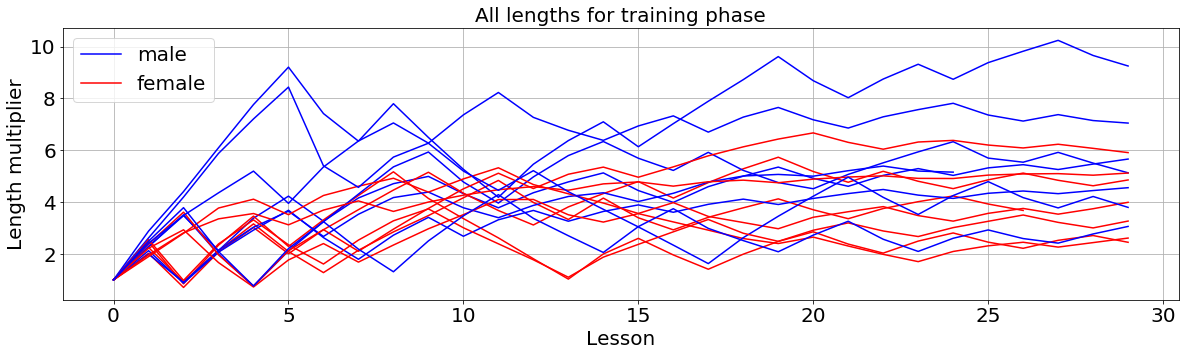

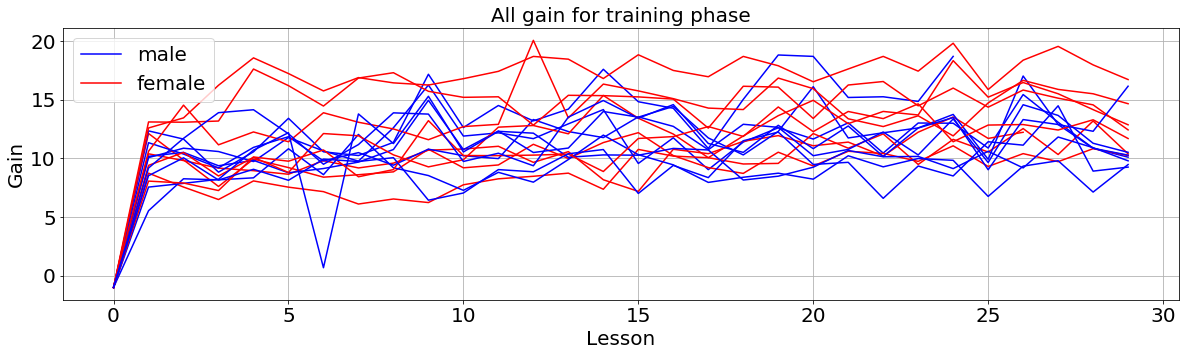

In [27]:
# phase1 results 
plt.rcParams['figure.figsize'] = [20, 5]
lengths = []
gainAllParticipants = [] 
for p in playersTraining:
    lengths.append(getResultPerPlayer(p, results, 28, True ))
    gainAllParticipants.append(getResultPerPlayer(p, results, 29, True ))

for i in range(len(lengths)): # print all lengths 
    l = lengths[i]
    x = list(range(0, len(l)))
    if(gender[playersTraining[i]] == 0):
        plt.plot(x, l, "b") 
    else:
        plt.plot(x, l, "r")

plt.title("All lengths for training phase")
plt.grid(True)
plt.ylabel("Length multiplier")
plt.xlabel("Lesson")
plt.savefig("AllLengthsPhase1",bbox_inches='tight', dpi=150)
plt.legend(["male", "female"], loc='upper left')
plt.show()

for i in range(len(gainAllParticipants)): 
    l = gainAllParticipants[i]
    x = list(range(0, len(l)))
    if(gender[playersTraining[i]] == 0):
        plt.plot(x, l, "b")   
       
    else:
        plt.plot(x, l, "r")
        
    
plt.title("All gain for training phase")
plt.grid(True)
plt.legend(["male", "female"], loc='upper left')
plt.ylabel("Gain")
plt.xlabel("Lesson")
plt.savefig("AllGainsPhase1",bbox_inches='tight', dpi=150)
plt.show()

sortedGain = []
sortedLengths = []




In [28]:
age = [25, 25, 27, 24, 27, 28, 25, 24, 26, 24, 25, 21, 32, 27, 26, 40]
heightM = [170, 177, 182, 181, 179, 180, 184, 185]
heightF = [173, 165, 172, 160, 170, 170, 165, 178]
print("Mean age: ", np.mean(age))
print("Mean height male: ", np.mean(heightM))
print("Mean height female: ", np.mean(heightF))

Mean age:  26.625
Mean height male:  179.75
Mean height female:  169.125


In [31]:
lengthsForAvg = []
fitnessForAvg = []

lengths = []
fintess = []

i = 0
for p in playersTraining:
    l = getResultPerPlayer(p, results, 28, True )
    l = [x * armLength[i] / 100 for x in l]
    lengths.append(l)
    f = getResultPerPlayer(p, results, 29, True )
    fintess.append(f)
    lengthsForAvg.append(l) 
    fitnessForAvg.append(f)
    i += 1
    
avgLengths = []

minLen = []
maxLen  = []

N = len(maleLengths)

topLen = max(list(map(lambda x: len(x), lengthsForAvg)))

for i in range(topLen):
    tmp = 0
    tmin = 100
    tmax = 0
    for j in range(N):
        try:
            t = lengthsForAvg[j][i]
            tmp += t
            if t < tmin:
                tmin = t
            if t > tmax:
                tmax = t
        except IndexError:
            print("nope M")
    avgLengths.append(tmp/maleN)
    maxLen.append(tmax)
    minLen.append(tmin)
    


nope M
nope M
nope M
nope M
nope M
nope M
nope M
nope M


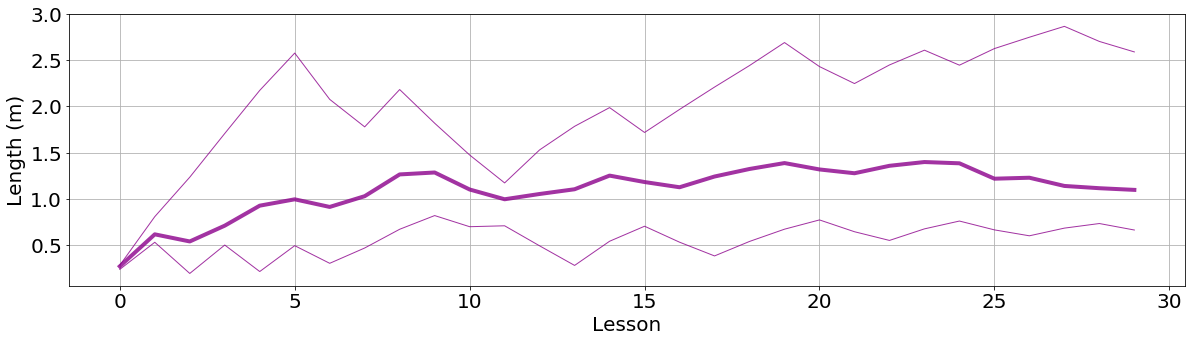

In [37]:
lengths = []
gainAllParticipants = []
colours = [red, blue]
width = [1,4,1,1,4,1]

tmp = [maxLen,avgLengths,minLen]

i = 0
for p in range(len(tmp)):
    plt.plot(range(len(tmp[p])), tmp[p], col1, linewidth = width[i], alpha=0.8)
    i += 1


plt.grid(True)
plt.ylabel("Length (m)")
plt.xlabel("Lesson")
plt.savefig("MeanLengthsTrainingTrend",bbox_inches='tight', dpi=150)
plt.show()

In [104]:

# fig, (ax1, ax2) = plt.subplots( ncols = 2)

# for p in range(len(vrLength)):
#     if gen[p] == 0:
#         ax1.scatter(armLength[p], vrLength[p], alpha=0.8, color=blue)
#     else:
#         ax1.scatter(armLength[p], vrLength[p], alpha=0.8, color=red)


# ax1.set_title('Forearm length to obtained length in VR')
# ax1.set_xlabel('Real life length [cm]')
# ax1.set_ylabel('VR Multiplier')
# ax1.legend(('male', 'female'), loc='best')

# for p in range(len(realLength)):
#     if gen[p] == 0:
#         ax2.scatter(armLength[p], realLength[p], alpha=0.8, color=blue)
#     else:
#         ax2.scatter(armLength[p], realLength[p], alpha=0.8, color=red)
# ax2.set_title('Forearm length to obtained length in VR')
# ax2.set_xlabel('Real life length [cm]')
# ax2.set_ylabel('VR Length [m]')

# ax2.legend(('male', 'female'), loc='best')

# fig.suptitle("Distribution of arms' lengths by forearm's length", y = 1.05)
# plt.savefig("ForeamrsLengthOverForearms",bbox_inches='tight', dpi=150)

# plt.show()

In [105]:
# plt.rcParams['figure.figsize'] = [20, 5]
# lengths = []
# gainAllParticipants = [] 
# for p in playersTraining:
#     lengths.append(getResultPerPlayer(p, results, 28, True ))
#     gainAllParticipants.append(getResultPerPlayer(p, results, 29, True ))


# for i in range(len(lengths)): # print all lengths 
#     l = lengths[i]
#     l = [x * armLength[i] / 100 for x in l]
#     x = list(range(0, len(l)))
#     if(gender[playersTraining[i]] == 0):
#         plt.plot(x, l, blue) 
#     else:
#         plt.plot(x, l, red)
        
# plt.title("Lengths' change trends during training phase")
# plt.grid(True)
# plt.ylabel("Length [m]")
# plt.xlabel("Lesson")
# plt.savefig("AllRealLengthsPhase1",bbox_inches='tight', dpi=150)
# plt.legend(["male", "female"], loc='upper left')
# plt.savefig("LengthsTrendTraining",bbox_inches='tight', dpi=150)
# plt.show()

In [106]:
# fig, (ax1, ax2) = plt.subplots( ncols = 2)

# for p in range(len(vrLength)):
#     if gen[p] == 0:
#         ax1.scatter(height[p], vrLength[p], alpha=0.8, color=blue)
#     else:
#         ax1.scatter(height[p], vrLength[p], alpha=0.8, color=red)


# ax1.set_title('Forearms\' multipier over participant\'s height')
# ax1.set_xlabel('Height [m]')
# ax1.set_ylabel('VR Multiplier')
# ax1.legend(('male', 'female'), loc='best')

# for p in range(len(realLength)):
#     if gen[p] == 0:
#         ax2.scatter(height[p], realLength[p], alpha=0.8, color=blue)
#     else:
#         ax2.scatter(height[p], realLength[p], alpha=0.8, color=red)
# ax2.set_title('Forearms\' lengths in VR over participant\'s height')
# ax2.set_xlabel('Height [m]')
# ax2.set_ylabel('VR Length [m]')

# ax2.legend(('male', 'female'), loc='best')

# fig.suptitle("Distribution of arms' lengths by height", y = 1.05)
# plt.savefig("ForeamrsLengthOverHeight",bbox_inches='tight', dpi=150)

# plt.show()

(7, 30)


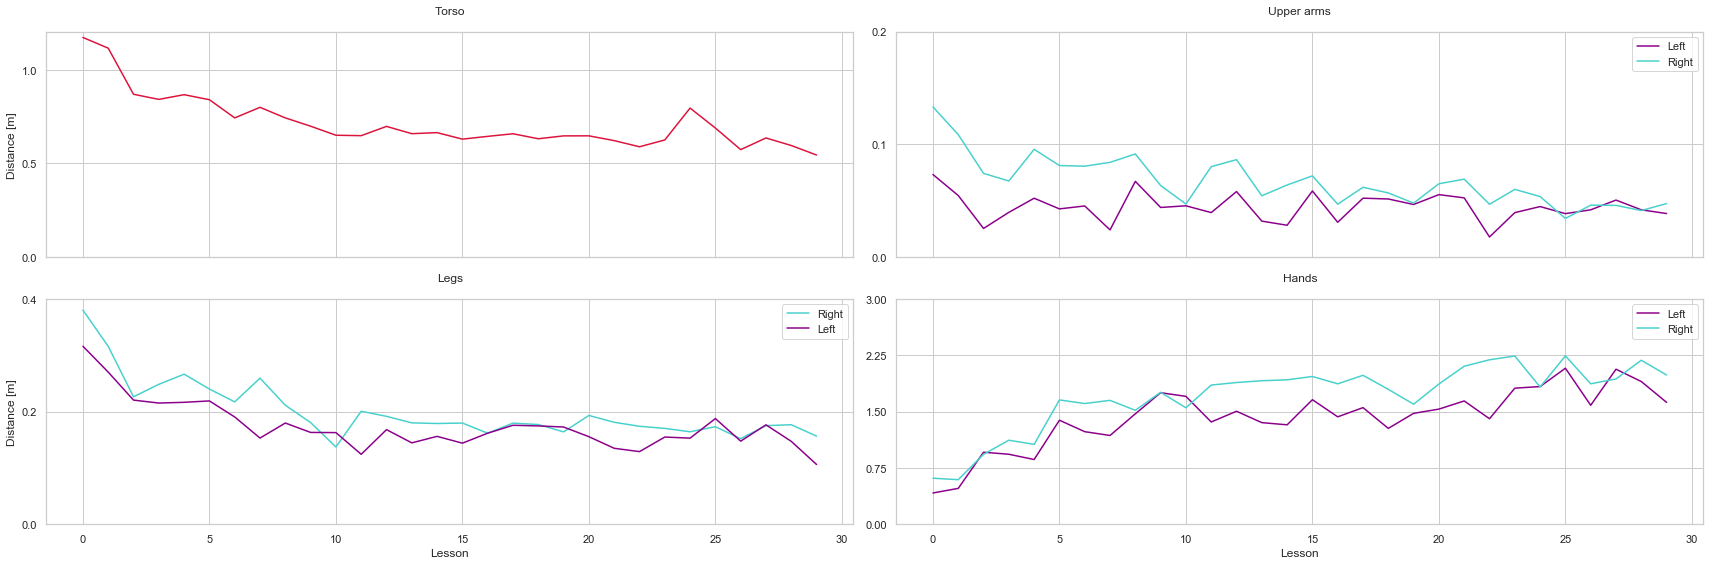

In [145]:
fig, ax = plt.subplots( ncols = 2, nrows=2, sharex=True, sharey=False)

first = True

for p in playersTraining:
    (efforts, dist) = EffortPerBodyPartPerPlayer(p,results)
    tmp = np.matrix(dist)
    if dist[0][6] > 5:
        continue
    if first:
        acc = tmp
        first = False
    else:
        if acc.shape != tmp.shape:
            (x,y) = acc.shape
            (a,b) = tmp.shape
            tmp = np.pad(tmp,((0,0),(0,y-b)),'constant')
        acc = np.add(acc,tmp)

avg = np.true_divide(acc,len(playersTraining))
avg = np.delete(avg, [30,31], axis=1).tolist()
print(np.shape(avg))
for i in range(len(avg)):
   
    y = avg[i]
    x = range(len(y))
    if (i > 0):
        y = [avg[i][k] - avg[0][k] for k in range(len(avg[i]))]
    
    if bodyPartsGroups[i] == 0:
        ax[0][0].plot(x,y, color = red)
        ax[0][0].set_title("Torso", y = 1.05)
        ax[0][0].set_yticks(np.arange(0,1.5, 0.5))
        ax[0][0].grid(True)
#         ax[0][0].legend((),loc='best')
    elif bodyPartsGroups[i] == 1:
        ax[0][1].plot(x,y, color = colours[i])
        ax[0][1].set_title("Upper arms", y = 1.05)
        ax[0][1].set_yticks(np.arange(0,0.3, 0.1))
        ax[0][1].grid(True)
        ax[0][1].legend(('Left', 'Right'), loc='best')
    elif bodyPartsGroups[i] == 3: 
        ax[1][1].plot(x,y, color = colours[i])
        ax[1][1].set_title("Hands", y = 1.05)
        ax[1][1].set_yticks(np.arange(0,3.25, 0.75))
        ax[1][1].legend(('Left', 'Right'), loc='best')
        ax[1][1].grid(True)
    else:
        ax[1][0].plot(x,y, color = colours[i])
        ax[1][0].set_title("Legs", y = 1.05)
        ax[1][0].legend(('Right', 'Left'), loc='best')
        ax[1][0].set_yticks(np.arange(0,0.6, 0.2))
        ax[1][0].grid(True)
        
ax[0][0].set_ylabel('Distance [m]')
ax[1][0].set_ylabel('Distance [m]')

ax[1][0].set_xlabel('Lesson')
ax[1][1].set_xlabel('Lesson')
  
plt.tight_layout(w_pad=0.5, h_pad=1.0)

# plt.subplots_adjust(top=1.5, bottom = 0.05)
plt.savefig("DistancesBodyPartsTraining2",bbox_inches='tight', dpi=150)
plt.show()

In [ ]:
first = True
fig, (ax1, ax2, ax3) = plt.subplots( ncols = 3)

for i in range(len(avg)):
    y = avg[i]
    x = range(len(y))
    if bodyPartsGroups[i] == 0:
        ax1.plot(x,y)
    elif bodyPartsGroups[i] == 1 or bodyPartsGroups[i] == 3:
        ax2.plot(x,y)
    else:
        ax3.plot(x,y)

plt.show()


In [ ]:
lHR = []
lHL = []
rHR = []
rHL = []
for i in range(len(playersTraining)):
    efforts, dist = EffortPerBodyPartPerPlayer(playersTraining[i],results)
    if hand[i] == 0:
        rHL.append(dist[5][:30])
        rHR.append(dist[6][:30])
    else:
        lHL.append(dist[5][:30])
        lHR.append(dist[6][:30])
        
fig, ax = plt.subplots( ncols = 2, nrows=2, sharex=True, sharey=True)

for y in rHR:
    ax[0][0].plot(range(len(y)), y)
    
for y in rHL:
    ax[0][1].plot(range(len(y)), y)

for y in lHR:
    ax[1][0].plot(range(len(y)), y)
    
for y in lHL:
    ax[1][1].plot(range(len(y)), y)
    
ax[0][0].set_title("Right Handed | Right Hand", y = 1.05)
ax[0][1].set_title("Right Handed | Left Hand", y = 1.05)
ax[1][0].set_title("Left Handed | Right Hand", y = 1.05)
ax[1][1].set_title("Left Handed | Left Hand", y = 1.05)

ax[0][0].set_ylabel('Distance [m]')
ax[1][0].set_ylabel('Distance [m]')

ax[1][0].set_xlabel('Lesson')
ax[1][1].set_xlabel('Lesson')

plt.tight_layout(w_pad=0.86, h_pad=1.0)
plt.subplots_adjust(top=1.5, bottom = 0.05)
fig.suptitle("Distances travelled by hands based on dominant hand during training phase", y = 1.75)
plt.savefig("HandednessDistancesTraining",bbox_inches='tight', dpi=150)
plt.show()



In [ ]:
lHR = 0
lHL = 0
rHR = 0
rHL = 0

k  = 0
m = 0
for i in range(len(playersTraining)):
    
    if hand[i] == 0:
        rHL += (distOptimal[i][5])
        rHR += (distOptimal[i][6])
        k += 1
    else:
        lHL +=(distOptimal[i][5])
        lHR += (distOptimal[i][6])
        m += 1
        
lHR = lHR / m
lHL = lHL / m
rHR = rHR / k
rHL = rHL / k      
n_groups = 2
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8

rightHand = [rHL, rHR]
leftHand = [lHL, lHR]

rects1 = plt.bar(index, leftHand, bar_width,
alpha=opacity,
color=red,
label='Left Handed')

rects2 = plt.bar(index + bar_width, rightHand, bar_width,
alpha=opacity,
color=blue,
label='Right Handed')


plt.xlabel('')
plt.ylabel('Avg Distance [m]')
plt.title('Handedness effect on distances travelled by hands')
plt.xticks(index + bar_width/2, ('Left Hand', 'Right Hand'))
plt.legend()
plt.grid(True)
plt.savefig("HandednessDistances",bbox_inches='tight', dpi=150)
plt.show()

In [ ]:
plotResultsPerBodyPart(distBaseline, distFirstTries, "Distance per body part", "Distance (m)", "DistancePerBodyPart") 